In [129]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
import random
import os
import json
import csv

# 1. Implementing your own Shazam

## 1.1 Getting your data 

### Some utility function:

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30   #TODO: to be tuned!
THRESHOLD = 0   #TODO: to be tuned!

### Convert tracks in the dataset from mp3 format to wav format.

In [4]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

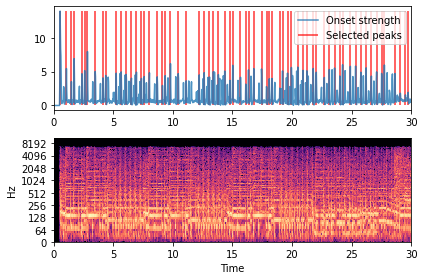

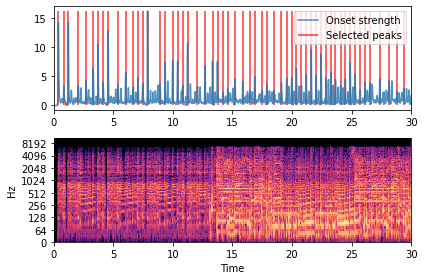

In [6]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)

## 1.2 Fingerprint hashing

In [79]:
tracks = data_folder.glob("*/*/*.wav")
for track in tracks:
    final=track
    final = os.path.normpath(final)
    #final = os.path.basename(final)
    final=final[14:]
    lst=final.partition('\\')
    final=lst[0]
    print(final)

aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
aerosmith
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatles
beatle

In [92]:
def track_vocabulary(tracks):
    voc={}
    i=0
    for track in tracks:
        name = os.path.basename(track)
        name=name[3:-4]

        path = os.path.normpath(track)
        final=path[14:]
        lst=final.partition('\\')
        author=lst[0]
        voc[(name, author)]=i
        i=i+1      
    return voc

In [ ]:
tracks = data_folder.glob("*/*/*.wav")
voc=track_vocabulary(tracks)
print(voc)

In [99]:
def get_name(track):
    name = os.path.basename(track)
    name=name[3:-4]

    path = os.path.normpath(track)
    final=path[14:]
    lst=final.partition('\\')
    author=lst[0]

    return (name, author)

In [27]:
def simple_hash(x, a, b, c):
    h = (a*x+b)%c
    return h

In [28]:
def random_number(n_permutation):
    random.seed(10010000)
    #our module is one of the Mersenne prime number, in particular the 31th 
    c=2147483647
    #as the ceil of the random number generator we had choosen the dimension of the unsigned long
    long=4294967295 
    a=random.sample(range(0, long), n_permutation)
    b=random.sample(range(0, long), n_permutation)
    return a, b, c

In [125]:
def fingerprint(tracks, n_permutation):
    a, b, c = random_number(n_permutation)
    fing={}
    for track in tracks:
        _, _, _, peaks = load_audio_picks(track, DURATION, HOP_SIZE)
        minimum=[]
        for i in range(0, n_permutation):
            h=[simple_hash(x, a[i], b[i], c) for x in peaks]
            minimum.append(min(h))
        
        name_author=get_name(track)
        fing[name_author]=minimum
        #print(name_author, fing[name_author])
    
    return fing

In [126]:
tracks = data_folder.glob("*/*/*.wav")
set_fingerprint=fingerprint(tracks, 10)

In [153]:
with open('./data/dataSignatures.csv', 'w', encoding="utf-8", newline="") as out_file:
    writer = csv.writer(out_file)
    for key, value in set_fingerprint.items():
        writer.writerow([key, value])

In [156]:
with open('./data/dataSignatures.csv', 'r', encoding='utf-8') as csv_file:
    dict_reader = csv.reader(csv_file)
    result={}
    for row in dict_reader:
        key = row[0]
        result[key] = row[1]
       


# 2. Grouping songs togheter

## 2.1 Getting your data!

In [7]:
dataset1 = pd.read_csv("data/file/echonest.csv")
dataset1.shape

(13129, 250)

In [8]:
dataset1.head(len(dataset1))

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.676960,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.082770,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.926490,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.414010,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.267070,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,-1.721207,4.686078,0.213789,0.208800,0.007911,0.06395,2.040730,1.97678,8.144532,147.040405
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,-0.647897,1.282306,0.214586,0.181860,0.011247,0.06240,0.922360,0.85996,1.794739,6.321268
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,-0.771613,1.623510,0.180471,0.128185,0.010103,0.06222,2.251160,2.18894,5.578341,89.180328
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,-2.054143,7.927149,0.250178,0.219205,0.014851,0.06390,1.487440,1.42354,2.173092,12.503966


In [9]:
dataset2 = pd.read_csv("data/file/features.csv")
dataset2.shape

(106574, 519)

In [10]:
dataset2.head(len(dataset2))

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
106570,155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
106571,155318,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
106572,155319,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


In [11]:
dataset3 = pd.read_csv("data/file/tracks.csv")
dataset3.shape

(106574, 53)

In [12]:
dataset3.head(len(dataset3))

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
106570,155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
106571,155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp
106572,155319,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,...,NaN,336,NaN,Creative Commons Attribution-NonCommercial-NoD...,294,NaN,5,NaN,[],The Man With Two Mouths


In [13]:
merge1 = pd.merge(dataset2, dataset3)
merged_final = (dataset1.merge(merge1, on='track_id', how='left'))
merged_final.shape

merged_final.to_csv('data/file/mergedfile.csv')

In [14]:
merged_final.head(len(merged_final))

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,NaN,20996,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,13365,NaN,8,NaN,[],I'm Wearing My Dancing Pants
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,NaN,4501,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3588,NaN,9,NaN,[],Me Funky You Jane
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,NaN,3641,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,2956,NaN,10,NaN,[],Ain't Mad at Ya
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,NaN,3960,NaN,Attribution-Noncommercial-Share Alike 3.0 Unit...,3126,NaN,11,NaN,[],This Is Not the End


## 2.2 Choose your features (variables)

## 2.3 Clustering

## 2.4 Analysing your results

# 3. Algorithmic question